## 1. Entropy and Mutual Information

Author: Cheuk Ting Li  (https://staff.ie.cuhk.edu.hk/~ctli/)

<< Back to [table of contents](table_of_contents.ipynb)

In [1]:
# If you are running this on Google Colab, uncomment and run the following:

# !apt-get install libgmp-dev python3-dev
# !pip install psitip

In [33]:
%matplotlib inline
# %matplotlib qt

import numpy
import matplotlib.pyplot as plt
from matplotlib import cm
from psitip import *
PsiOpts.setting(
    solver = "ortools.GLOP",    # Set linear programming solver
    str_style = "std",          # Conventional notations in output
    solve_display_reg = True,   # Display claims in solve commands
    proof_note_color = "blue",  # Reasons in proofs are blue
    str_float = True,           # Print floating points, not fractions
    random_seed = 123,          # Random seed
    figsize = (5,5)             # Default figure size for info diagrams
)
X, Y, Z = rv("X, Y, Z")         # Declare random variables

## 1.1  Entropy

Given a random variable $X$ with probability mass function $p_X(x)$, its **Shannon entropy** is defined as
$$H(X) = \mathbf{E}\left[\log \frac{1}{p_X(X)} \right] = \sum_x p_X(x) \log \frac{1}{p_X(x)}$$

Assume $0 \log (1/0)=0$. We assume log is to the base 2. In this case, the unit of entropy is **bits**. If base $e$ is used, then the unit is **nats**.

Entropy measures the amount of information in $X$ in the following senses:

- $H(X)$ is approximately the number of bits needed to compress $X$. In Huffman coding, the average number of bits needed to compress $X$ is bounded between $H(X)$ and $H(X)+1$. If we are going to compress an i.i.d. sequence $X_1,\ldots,X_n$, the number of bits needed is $n H(X) + o(n)$.

- $H(X)$ is approximately the number of fair coin flips needed to generate $X$. In the Knuth-Yao scheme [Knuth-Yao 1976], the average number of fair coin flips needed to generate $X$ is bounded between $H(X)$ and $H(X)+2$. If we are going to generate an i.i.d. sequence $X_1,\ldots,X_n$, the number of coin flips needed is $n H(X) + o(n)$.


Plot of $H(X)$ for $X \sim \mathrm{Bern}(a)$, i.e., $X$ follows the Bernoulli distribution $p_X(0)=1-a$, $p_X(1)=a$:

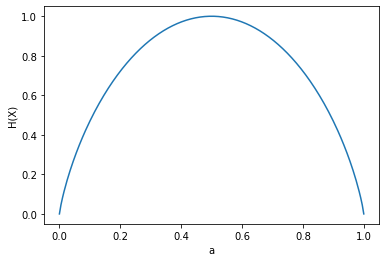

In [3]:
# Define the binary entropy function
def H_bin(a):
    P = ConcModel()       # A concrete model holds the distribution information of RVs
    P[X] = [1 - a, a]     # Set distribution of X
    return float(P[H(X)]) # Get H(X) according to P

alist = numpy.linspace(0, 1, 200)
plt.figure()
plt.plot(alist, numpy.vectorize(H_bin)(alist))
plt.xlabel("a")
plt.ylabel("H(X)")
plt.show()

Plot of $H(X)$ for $p_X(1)=a$, $p_X(2)=b$, $p_X(3)=1-a-b$:

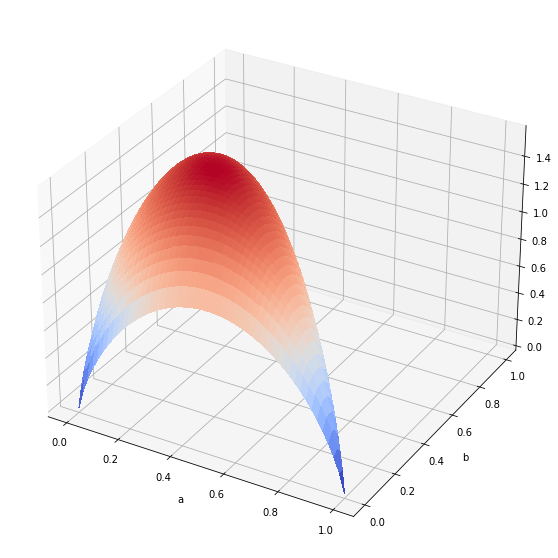

In [34]:
# Define the ternary entropy function
def H_ter(a, b):
    P = ConcModel()
    P[X] = [a, b, 1 - a - b]
    return float(P[H(X)])

alist = numpy.linspace(0, 1, 50)
alist, blist = numpy.meshgrid(alist, alist)
blist = numpy.minimum(blist, 1 - alist)  # Ensure b <= 1-a
plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(alist, blist, numpy.vectorize(H_ter)(alist, blist), 
                cmap=cm.coolwarm, antialiased=False)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

### Joint Entropy

Given random variables $X,Y$, their **joint entropy** is
$$H(X,Y) = \mathbf{E}\left[\log \frac{1}{p_{X,Y}(X,Y)} \right] = \sum_{x,y} p_{X,Y}(x,y) \log \frac{1}{p_{X,Y}(x,y)}$$
This is not a new concept. It is merely the entropy of the joint random variable $(X,Y)$ treated as a 2D random vector. Intuitively, $(X,Y)$ is the "union of the information in $X$ and $Y$".

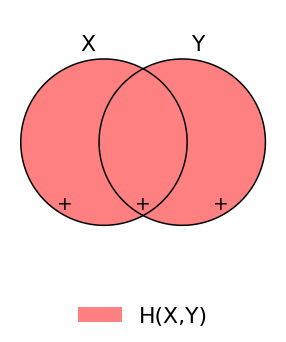

In [5]:
H(X,Y).venn(style="notext")

### Properties of Entropy

1. $H(X) \ge 0$, and $H(X)=0$ iff $X$ is (almost surely) a constant.


2. If $X \in \{1,...,k\}$, then $H(X) \le \log k$. Equality iff $X$ is uniform over $\{1,...,k\}$.

  *Proof.* To prove this, we invoke the log sum inequality: for sequences $a_1,\ldots,a_n,b_1,\ldots,b_n \ge 0$ with $a=\sum_i a_i$, $b=\sum_i b_i$, we have
  $$\sum_i a_i \log \frac{a_i}{b_i} \ge a \log \frac{a}{b}$$
  Equality holds iff $a_i/b_i$ are equal over all $i$'s.
  
  We obtain $H(X) \le \log k$ by taking $a_i = p_X(i)$, $b_i=1/k$ for $i=1,\ldots,k$.
  
  Example:

In [6]:
k = 5
P = ConcModel()
P[X] = [1 / k] * k
display(P)
display(H(X) == P[H(X)])

H(X) == 2.32193 

3. If $f$ is a function, then $H(f(X)) \le H(X)$. Equality holds if $f$ is injective.

  - As a result, $H(X) \le H(X,Y)$

In [7]:
(H(X) <= H(X,Y)).solve()

H(X) <= H(X+Y)  is True

4. (Subadditivity). $H(X,Y)\le H(X)+H(Y)$. Equality iff $X,Y$ are independent.

  *Proof.* Log sum inequality on $a_{x,y}=p_{X,Y}(x,y)$, $b_{x,y}=p_X(x)p_Y(y)$.

In [8]:
display((H(X,Y) <= H(X) + H(Y)).solve())
display((indep(X, Y) == (H(X,Y) == H(X) + H(Y))).solve())

H(X+Y) <= H(X)+H(Y)  is True

(
  (  (  H(X+Y) == H(X)+H(Y)  )
  >> (  indep(X, Y)  ))
 &
  (  (  indep(X, Y)  )
  >> (  H(X+Y) == H(X)+H(Y)  ))
) is True

What is the range of possible values of $H(X,Y)$ given $H(X)$ and $H(Y)$?

In [39]:
# Enumerate inequalities betweeen H(X,Y), H(X), H(Y)
universe().discover([(real(str(t)), t) for t in [H(X,Y), H(X), H(Y)]])

( ( H(X) <= H(X,Y) )
 &( H(Y) <= H(X,Y) )
 &( H(X,Y) <= H(X)+H(Y) ) )

5. (Concavity). $H(X)$ is concave in $p_X$

  - Although we write $H(X)$, we can see in the definition that entropy is actually a function of the pmf $p_X$, not a function of the particular value that $X$ takes. It is technically more accurate to write $H(p_X)$ instead of $H(X)$. The concavity of entropy means that the function $H(p_X)$ is concave in $p_X$.
  
  - See Conditional Entropy section for proof.

In [9]:
H(X).isconcave(X)

True

----------------

## 1.2  Conditional Entropy

Given a random variable $Y$ and an event $E$, the **conditional entropy** of $Y$ given $E$ is
$$H(Y|E) = \mathbf{E}\left[\log \frac{1}{p_{Y|E}(Y)} \,\bigg|\, E \right] = \sum_y p_{Y|E}(y) \log \frac{1}{p_{Y|E}(y)}$$
It is merely the entropy of the conditional pmf $p_{Y|E}$.

Given random variables $X,Y$, the **conditional entropy** of $Y$ given $X$ is
\begin{align}
H(Y|X) &= \mathbf{E}\left[\log \frac{1}{p_{Y|X}(Y|X)} \right] \\
&= \sum_x p_X(x) H(Y|X=x) \\
&= \sum_{x,y} p_{X,Y}(x,y) \log \frac{1}{p_{Y|X}(y|x)}
\end{align}
It is the weighted average value of $H(Y|X=x)$, averaged over the distribution $p_X$. Intuitively, this is the amount of information left in $Y$ if we already know $X$.

### Conditional Entropy vs Set Difference

It is tempting to treat $H(Y|X)$ as "the entropy of the difference $Y\backslash X$". Indeed, $H(Y|X)$ shares some similarities as the size of the set difference.

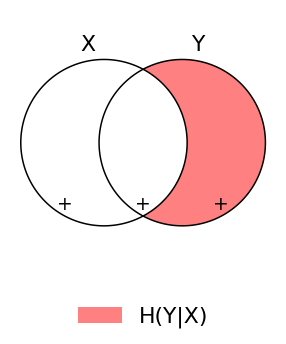

In [10]:
H(Y|X).venn(X, Y, style="notext")

For example, for sets $A,B$, we have $|B\backslash A| = |A \cup B| - |A|$. Analogously, we have
$$H(Y|X) = H(X,Y)-H(X)$$
This follows from straightforward algebraic manipulations.

In [11]:
(H(Y|X) == H(X,Y)-H(X)).solve()

H(X)+H(Y|X) == H(X+Y)  is True

Nevertheless, it is important to note that "$Y|X$" does **not** represent a random variable, and $H(Y|X)$ is not "the entropy of the difference random variable".

### Properties of Conditional Entropy

1. $H(Y|X) = 0$ iff $Y$ is (almost surely) a function of $X$.
  - In particular, $H(X|X)=0$
  

2. (Condition decreases entropy) $H(Y|X) \le H(Y)$.
  - Consequence of $H(X,Y) \le H(X)+H(Y)$.
  - For event $E$, $H(Y|E) \le H(Y)$ **may or may not** hold.

In [12]:
(H(Y|X) <= H(Y)).solve()

H(Y|X) <= H(Y)  is True

We can use $H(Y|X) \le H(Y)$ to prove that $H(X)=H(p_X)$ is concave in $p_X$. Consider probability mass functions $p_X^{(1)},\ldots ,p_X^{(n)}$ over the same set, and a random integer $K \in \{1,\ldots,n\}$ with probability mass function $p_K$. The concavity of $H(p_X)$ means that
$$\mathbf{E}_K[H(p_X^{(K)})] \le H(\mathbf{E}_K[p_X^{(K)}])$$
where $\mathbf{E}_K[p_X^{(K)}]$ is the function $x \mapsto \mathbf{E}_K[p_X^{(K)}(x)]$, i.e., the weighted average of the pmfs $p_X^{(1)},\ldots ,p_X^{(n)}$, which is also a probability mass function.

Assume $X$ is generated according to $p_X^{(K)}$ conditional on $K$, i.e., $p_{X|K}(x|k)=p_X^{(k)}(x)$. We can check that $p_X = \mathbf{E}_K[p_X^{(K)}]$, and hence $H(\mathbf{E}_K[p_X^{(K)}])=H(X)$. By definition of conditional entropy, $\mathbf{E}_K[H(p_X^{(K)})]=H(X|K)$. Therefore, concavity follows from $H(X|K) \le H(X)$.

----------------

## 1.3 Mutual Information

Given random variables $X,Y$, their **mutual information** is
\begin{align}
I(X;Y) &= H(X)+H(Y)-H(X,Y)\\
&= H(Y)-H(Y|X) \\
&= \mathbf{E}\left[\log \frac{p_{X,Y}(X,Y)}{p_X(X)p_Y(Y)} \right]
\end{align}
This parallels set intersection, which satisfies $|A \cap B| = |A|+|B|-|A\cup B| = |B|-|B \backslash A|$. Intuitively, $I(X;Y)$ measures the amount of information shared between $X$ and $Y$.


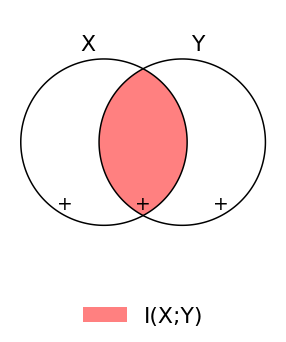

In [13]:
I(X & Y).venn(style="notext")

Note that "$X;Y$" does **not** represent a random variable, and $I(X;Y)$ is not "the entropy of the intersection random variable". Generally, one may not be able to find a random variable $Z$ that is a function of $X$, is also a function of $Y$, and satisfies $H(Z)=I(X;Y)$. If all entries in the joint pmf $p_{X,Y}(x,y)$ are positive, then the only $Z$ that is both a function of $X$ and a function of $Y$ is a constant random variable. See [Gács-Körner 1973] for more discussions.

### Properties of Mutual Information

1. $I(X;Y)\ge 0$. Equality iff $X,Y$ are independent.

  - Consequence of $H(X,Y) \le H(X)+H(Y)$.


2. $I(X;Y) \le \min\{H(X),H(Y)\}$

In [14]:
(I(X & Y) <= emin(H(X), H(Y))).solve()

I(X&Y) <= emin(H(X), H(Y))  is True

3. If $(X,Y)$ follows $p_X(x)p_{Y|X}(y|x)$, for any fixed $p_{Y|X}$, $I(X;Y)$ is a concave function of $p_X$.

  - Proof given in next chapter.

In [15]:
# The argument bnet = (X, Y) (the Bayesian network X -> Y) 
# means that the distribution is factorized as p_X p_{Y|X}
I(X & Y).isconcave(X, bnet = (X, Y)) # I(X;Y) concave in p_X

True

4. If $(X,Y)$ follows $p_X(x)p_{Y|X}(y|x)$, for any fixed $p_X$, $I(X;Y)$ is a convex function of $p_{Y|X}$.

  - Proof given in next chapter.

In [16]:
I(X & Y).isconvex(Y, bnet = (X, Y)) # I(X;Y) convex in p_{Y|X}

True

This means $I(X;Y)$ is a "concave-convex" function of $p_X$ and $p_{Y|X}$. We plot $I(X;Y)$ for $X \sim \mathrm{Bern}(a)$ and $p_{Y|X}(0|0)=p_{Y|X}(1|1)=1-b$, $p_{Y|X}(1|0)=p_{Y|X}(0|1)=b$ (i.e., $X \to Y$ is a binary symmetric channel with crossover probability $b$) against $a, b$. We can see that the plot looks like a horse saddle.

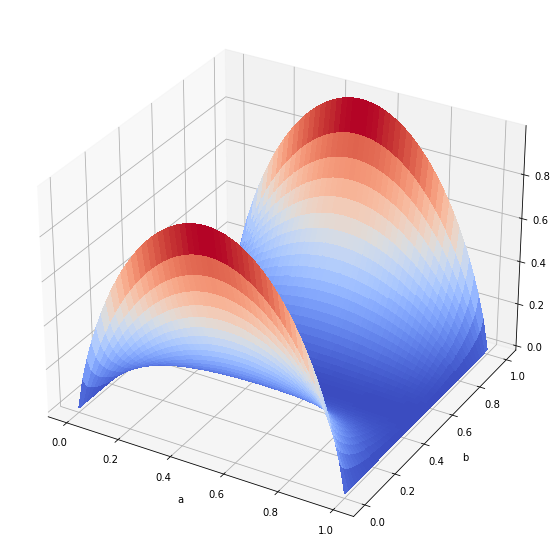

In [26]:
def I_plot(a, b):
    P = ConcModel()
    P[X] = [1 - a, a]                  # Set p_X
    P[Y|X] = [[1 - b, b], [b, 1 - b]]  # Set p_{Y|X}
    return float(P[I(X & Y)])          # Get I(X;Y)

alist = numpy.linspace(0, 1, 50)
alist, blist = numpy.meshgrid(alist, alist)
plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(alist, blist, numpy.vectorize(I_plot)(alist, blist), 
                cmap=cm.coolwarm, antialiased=False)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

----------------

## 1.4 Conditional Mutual Information

Given random variables $X,Y$ and event $E$, the **conditional mutual information** is
\begin{align}
I(X;Y|E) &= H(X|E)+H(Y|E)-H(X,Y|E)\\
&= H(Y|E)-H(Y|X,E) \\
&= \mathbf{E}\left[\log \frac{p_{X,Y|E}(X,Y)}{p_{X|E}(X)p_{Y|E}(Y)} \,\bigg|\, E \right]
\end{align}

Given random variables $X,Y,Z$, the **conditional mutual information** is
\begin{align}
I(X;Y|Z) &= H(X|Z)+H(Y|Z)-H(X,Y|Z)\\
&= H(Y|Z)-H(Y|X,Z) \\
&= \sum_z p_Z(z) I(X;Y|Z=z)\\
&= \mathbf{E}\left[\log \frac{p_{X,Y|Z}(X,Y|Z)}{p_{X|Z}(X|Z)p_{Y|Z}(Y|Z)} \right]
\end{align}
It is the weighted average value of $I(X;Y|Z=z)$, averaged over the distribution $p_Z$.

### Properties of Conditional Mutual Information

1. $I(X;Y|Z) \ge 0$. Equality holds iff $X,Y$ are conditionally independent given $Z$.


  - Many linear inequalities about entropy and mutual information can be proved using $I(X;Y|Z) \ge 0$. These inequalities are called **Shannon-type inequalities** [Yeung 2008]. 
  
  
  - Expanding this, we have
  $$H(X,Z)+H(Y,Z) \ge H(X,Y,Z)+H(Z)$$
  As a result, for a sequence of random variables $X_1,\ldots,X_n$, and sets $A,B \subseteq \{1,\ldots,n\}$, we have
  $$H(X_A)+H(X_B) \ge H(X_{A\cup B})+H(X_{A \cap B})$$
  where we write $X_A$ to be the joint random variable of $X_i$'s for $i \in A$. This means that entropy is a **submodular set function** [Fujishige 1978].
  

2. Note that $I(X;Y|Z)$ may be larger or smaller than $I(X;Y)$.

In [18]:
# Invoking .solve(full=True), PSITIP will attempt to prove
# the statement or find a counterexample
res = (I(X & Y | Z) >= I(X & Y)).solve(full=True)
display(res)
print(float(res.model[I(X & Y | Z)]))
print(float(res.model[I(X & Y)]))

I(X&Y) <= I(X&Y|Z)  is False

P(X+Y+Z) = tensor([[[0.0000, 0.5000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.5000, 0.0000]]], dtype=torch.float64, grad_fn=<CopySlices>)


0.0
0.9999999855730495


For example, if $X=Y=Z \sim \mathrm{Bern}(1/2)$, then $I(X;Y|Z)=0$, $I(X;Y)=1$.

In [19]:
P = ConcModel()
P[X] = [1/2, 1/2]
P[Y|X] = "equal"  # Y = X
P[Z|X] = "equal"  # Z = X

print(P[I(X & Y | Z)])
print(P[I(X & Y)])

0.0
1.0


In [20]:
res = (I(X & Y | Z) <= I(X & Y)).solve(full=True)
display(res)
print(float(res.model[I(X & Y | Z)]))
print(float(res.model[I(X & Y)]))

I(X&Y|Z) <= I(X&Y)  is False

P(X+Y+Z) = tensor([[[0.0000, 0.2500],
         [0.2500, 0.0000]],

        [[0.2500, 0.0000],
         [0.0000, 0.2500]]], dtype=torch.float64, grad_fn=<CopySlices>)


0.9999999711460998
1.4426949412893464e-08


If $X,Y \sim \mathrm{Bern}(1/2)$ i.i.d., and $Z = X \oplus Y$ (addition mod 2), then $I(X;Y|Z)=1$, $I(X;Y)=0$.

In [21]:
P = ConcModel()
P[X] = [1/2, 1/2]

# If Y is not introduced using P[Y|X], it is assumed to be indep. of X
P[Y] = [1/2, 1/2]

# One may also specify a function instead of a conditional pmf
P[Z|X,Y] = lambda x, y: (x + y) % 2

print(P[I(X & Y | Z)])
print(P[I(X & Y)])

1.0
0.0


**\>> [Next Chapter](learnit_infodiagram.ipynb)**

#### References

- T. M. Cover and J. A. Thomas, Elements of information theory, John Wiley & Sons, 2006.
- R. W. Yeung, Information theory and network coding, Springer Science & Business Media, 2008.
- D. E. Knuth and A. C. Yao, The complexity of nonuniform random number generation, 1976.
- P. Gács and J Körner, "Common information is far less than mutual information," Problems of Control and Information Theory 2.2: 149-162, 1973.
- S. Fujishige, "Polymatroidal dependence structure of a set of random variables," Information and control 39.1: 55-72, 1978.